## 2. ML Feature Transformations

- In this notebook, we will walk through a few transformations that are included in the Snowpark ML Preprocessing API. 
- We will also build a preprocessing pipeline to be used in the ML modeling notebook.

***Note: All feature transformations using Snowpark ML are distributed operations in the same way that Snowpark DataFrame operations are.***

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import json
import joblib

# warning suppresion
import warnings; warnings.simplefilter('ignore')

### Establish Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [2]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#  
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : SIKHADAS
Role                        : "ACCOUNTADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 7.21.1
Snowpark for Python version : 1.4.0


In [3]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
DEMO_TABLE = 'diamonds'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

### Data Loading

In [4]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
diamonds_df = session.table(input_tbl)

### Feature Transformations

We will illustrate a few of the transformation functions here, but the rest can be found in the [documentation](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-preprocessing).

##### Let's use the `MinMaxScaler` to normalize the `CARAT` column.

In [5]:
# Normalize the CARAT column
snowml_mms = snowml.MinMaxScaler(input_cols=["CARAT"], output_cols=["CARAT_NORM"])
normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Reduce the number of decimals
new_col = normalized_diamonds_df.col("CARAT_NORM").cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column("CARAT_NORM", new_col)

normalized_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |"CARAT_NORM"  |
-------------------------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326.0    |3.95  |3.98  |2.43  |IDEAL      |0.006237      |
|0.21     |E        |SI1        |59.8     |61.0         |326.0    |3.89  |3.84  |2.31  |PREMIUM    |0.002079      |
|0.23     |E        |VS1        |56.9     |65.0         |327.0    |4.05  |4.07  |2.31  |GOOD       |0.006237      |
|0.29     |I        |VS2        |62.4     |58.0         |334.0    |4.2   |4.23  |2.63  |PREMIUM    |0.018711      |
|0.31     |J        |SI2        |63.3     |58.0         |335.0    |4.34  |4.35  |2.75  |GOOD       |0.022869      |
|0.24     |J        |VVS2       |62.8     |57.0         |336.0    |3.94 

##### Let's use the `OrdinalEncoder` to transform `COLOR` and `CLARITY` from categorical to numerical values so they are more meaningful.

In [6]:
# Encode CUT and CLARITY preserve ordinal importance
categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=["CUT", "CLARITY"], output_cols=["CUT_OE", "CLARITY_OE"], categories=categories)
ord_encoded_diamonds_df = snowml_oe.fit(normalized_diamonds_df).transform(normalized_diamonds_df)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_diamonds_df.show()

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9
---------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OE"  |"CLARITY_OE"  |"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |"CARAT_NORM"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|0.0       |6.

##### Let's use the `OneHotEncoder` to transform the categorical columns to numerical columns.

This is more for illustration purposes. Using the OrdinalEncoder makes more sense for the diamonds dataset since `CARAT`, `COLOR`, and `CLARITY` all follow a natural ranking order.

In [7]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["CUT", "COLOR", "CLARITY"], output_cols=["CUT_OHE", "COLOR_OHE", "CLARITY_OHE"])
transformed_diamonds_df = snowml_ohe.fit(ord_encoded_diamonds_df).transform(ord_encoded_diamonds_df)

np.array(transformed_diamonds_df.columns)

array(['CUT_OHE_FAIR', 'CUT_OHE_GOOD', 'CUT_OHE_IDEAL', 'CUT_OHE_PREMIUM',
       'CUT_OHE_VERY_GOOD', 'COLOR_OHE_D', 'COLOR_OHE_E', 'COLOR_OHE_F',
       'COLOR_OHE_G', 'COLOR_OHE_H', 'COLOR_OHE_I', 'COLOR_OHE_J',
       'CLARITY_OHE_I1', 'CLARITY_OHE_IF', 'CLARITY_OHE_SI1',
       'CLARITY_OHE_SI2', 'CLARITY_OHE_VS1', 'CLARITY_OHE_VS2',
       'CLARITY_OHE_VVS1', 'CLARITY_OHE_VVS2', 'CUT_OE', 'CLARITY_OE',
       'CARAT', 'COLOR', 'CLARITY', 'DEPTH', 'TABLE_PCT', 'PRICE', 'X',
       'Y', 'Z', 'CUT', 'CARAT_NORM'], dtype='<U17')

##### Finally, we can also build out a full preprocessing `Pipeline`.

This will be useful for both the ML training & inference steps to have standarized feature transformations.

In [8]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

In [9]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(
                    input_cols=CATEGORICAL_COLUMNS,
                    output_cols=CATEGORICAL_COLUMNS_OE,
                    categories=categories,
                )
            ),
            (
                "MMS",
                snowml.MinMaxScaler(
                    clip=True,
                    input_cols=NUMERICAL_COLUMNS,
                    output_cols=NUMERICAL_COLUMNS,
                )
            )
    ]
)

PIPELINE_FILE = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first

transformed_diamonds_df = preprocessing_pipeline.fit(diamonds_df).transform(diamonds_df)
transformed_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326.0    |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

In [10]:
# You can also save the pickled object into the stage we created earlier for deployment
session.file.put(PIPELINE_FILE, "@DIAMONDS_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2059, target_size=1120, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

### Data Exploration

Now that we've transformed our features, let's calculate the correlation using Snowpark ML's `correlation()` function between each pair to better understand their relationships.

*Note: Snowpark ML's pearson correlation function returns a Pandas DataFrame*

In [11]:
corr_diamonds_df = correlation(df=transformed_diamonds_df)
corr_diamonds_df # This is a Pandas DataFrame

,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,PRICE
CARAT,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.134967,0.291437,0.352841,0.921591
DEPTH,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,0.218055,0.047279,0.067384,-0.010647
TABLE_PCT,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.433405,0.026465,0.160327,0.127134
X,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.125565,0.270287,0.371999,0.884435
Y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.121462,0.263584,0.358420,0.865421
Z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.149323,0.268227,0.366952,0.861249
CUT_OE,0.134967,0.218055,0.433405,0.125565,0.121462,0.149323,1.000000,0.020519,0.189175,0.053491
COLOR_OE,0.291437,0.047279,0.026465,0.270287,0.263584,0.268227,0.020519,1.000000,-0.025631,0.172511
CLARITY_OE,0.352841,0.067384,0.160327,0.371999,0.358420,0.366952,0.189175,-0.025631,1.000000,0.146800
PRICE,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,0.053491,0.172511,0.146800,1.000000


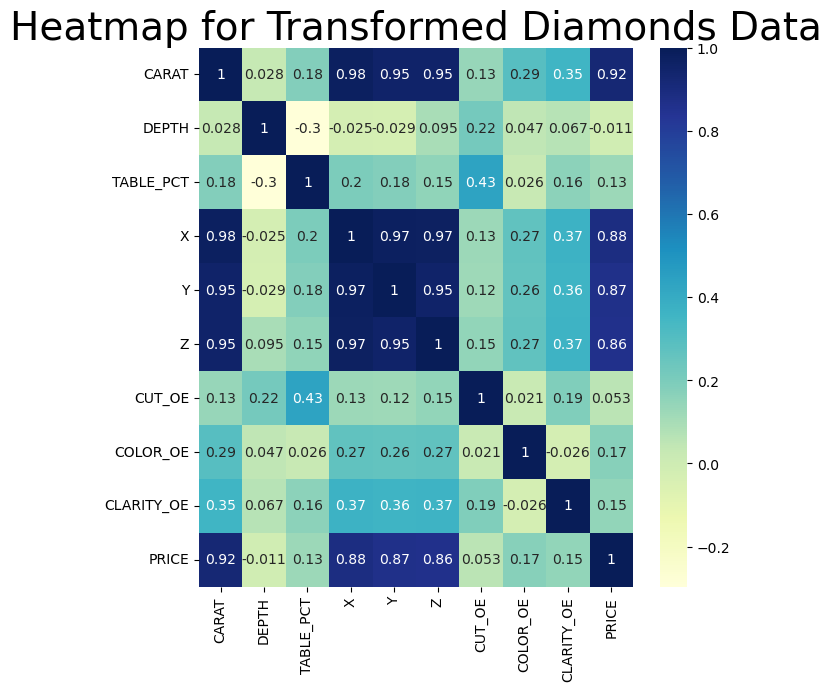

In [12]:
# Create a heatmap with the features
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Heatmap for Transformed Diamonds Data', fontsize=28)
dataplot = sns.heatmap(corr_diamonds_df, cmap="YlGnBu", annot=True)

plt.show()

We note that `CARAT` and `PRICE` are highly correlated, which makes sense! Let's take a look at their relationship a bit closer.

*Note: You will have to convert your Snowpark DF to a Pandas DF in order to use matplotlib & seaborn.*

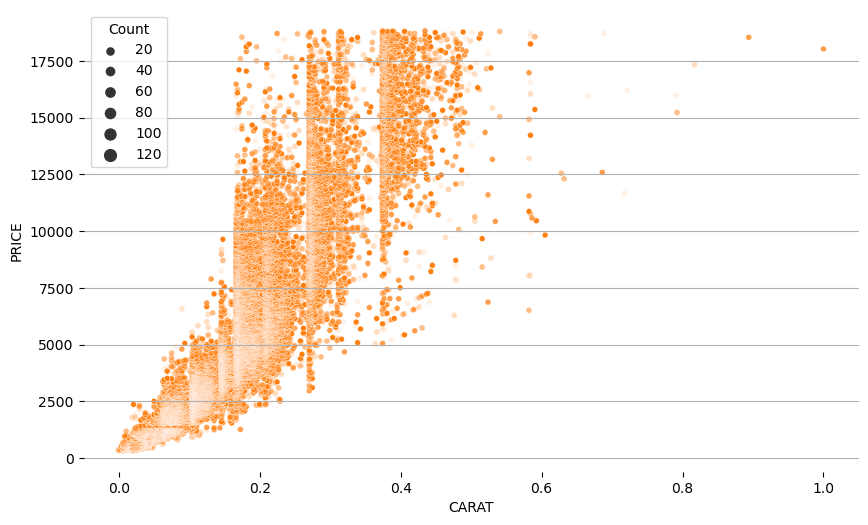

In [13]:
# Set up a plot to look at CARAT and PRICE
counts = transformed_diamonds_df.to_pandas().groupby(['PRICE', 'CARAT']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(data=counts, x='CARAT', y='PRICE', size='Count', markers='o', alpha=(0.1, .25, 0.5, 0.75, 1))
ax.grid(axis='y')

# The relationship is not linear - it appears exponential which makes sense given the rarity of the large diamonds
sns.move_legend(ax, "upper left")
sns.despine(left=True, bottom=True)

In [14]:
session.close()